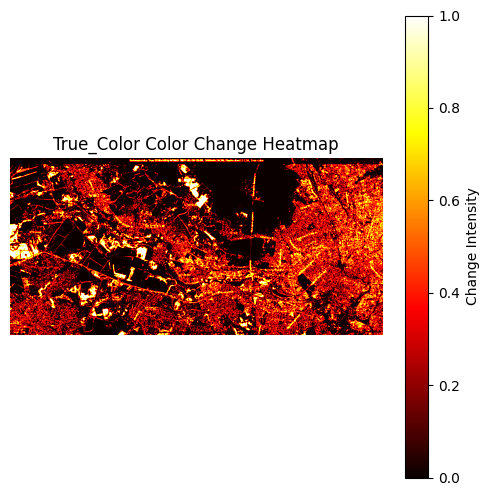

[+] Overlay saved: ../data/output/change_maps/true_color_overlay.png
[+] 749 changes annotated for true_color imagery.


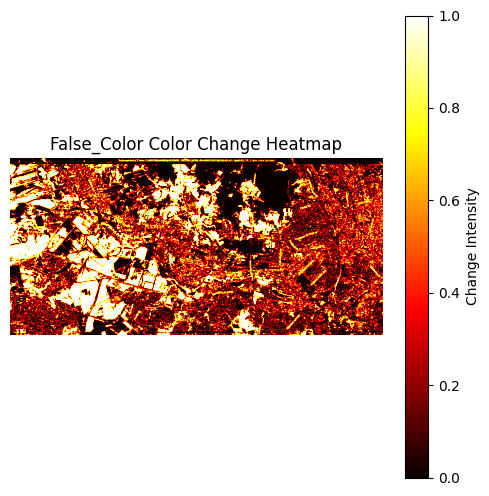

[+] Overlay saved: ../data/output/change_maps/false_color_overlay.png
[+] 790 changes annotated for false_color imagery.
[+] Intelligence report created: ../reports/true_color_intelligence_report.md
[+] Intelligence report created: ../reports/false_color_intelligence_report.md


In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects
import os

# This notebook processes satellite images to detect changes between two dates,
# creates annotated overlays, and generates intelligence reports.

# === STEP 1: Load Images ===
paths = {
    "true_color_may": "../data/satellite_images/solonytsivka_may2022_truecolor.png",
    "true_color_june": "../data/satellite_images/solonytsivka_jun2022_truecolor.png",
    "false_color_may": "../data/satellite_images/solonytsivka_may2022_falsecolorurban.png",
    "false_color_june": "../data/satellite_images/solonytsivka_jun2022_falsecolorurban.png"
}

images = {key: Image.open(path).convert("RGB") for key, path in paths.items()}

# === STEP 2: Resize all images to match ===
base_size = images["true_color_may"].size # (width, height)
for key in images:
    if images[key].size != base_size: 
        images[key] = images[key].resize(base_size) 

# === STEP 3: Create Change Detection Function ===
def create_diff_mask(img_before, img_after, threshold=40):
    arr1 = np.array(img_before, dtype=np.int16)
    arr2 = np.array(img_after, dtype=np.int16)
    diff = np.abs(arr2 - arr1)
    diff_gray = diff.sum(axis=2)
    mask = (diff_gray > threshold).astype(np.uint8)
    return mask

# === STEP 4: Overlay + Annotate ===
def overlay_and_annotate(after_img, mask, label_prefix, save_path):
    labeled, num_features = label(mask)
    regions = find_objects(labeled)
    overlay = after_img.convert("RGBA")
    draw = ImageDraw.Draw(overlay)

    annotations = []
    for i, region in enumerate(regions):
        if region is None:
            continue
        y1, y2 = region[0].start, region[0].stop
        x1, x2 = region[1].start, region[1].stop
        area = (x2 - x1) * (y2 - y1)
        if area < 150:
            continue
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1 - 12), f"Change {i+1}", fill="red")
        annotations.append({
            "label": f"{label_prefix} Change {i+1}",
            "x1": x1, "y1": y1, "x2": x2, "y2": y2, "area": area
        })

    overlay.save(save_path)
    print(f"[+] Overlay saved: {save_path}")
    return annotations

# === STEP 5: Process Both Image Types ===
os.makedirs("../data/output/change_maps", exist_ok=True)
reports = {}

for mode in ["true_color", "false_color"]:
    may = images[f"{mode}_may"]
    june = images[f"{mode}_june"]

    mask = create_diff_mask(may, june)
    plt.figure(figsize=(6,6))
    plt.imshow(mask, cmap='hot')
    plt.title(f"{mode.title()} Color Change Heatmap")
    plt.axis('off')
    plt.colorbar(label="Change Intensity")
    plt.savefig(f"../data/output/change_maps/{mode}_heatmap.png", bbox_inches='tight')
    plt.show()

    overlay_path = f"../data/output/change_maps/{mode}_overlay.png"
    annotations = overlay_and_annotate(june, mask, mode.title(), overlay_path)
    reports[mode] = annotations
    print(f"[+] {len(annotations)} changes annotated for {mode} imagery.")

# === STEP 6: Generate Intelligence Reports ===
def write_report(mode, annotations):
    path = f"../reports/{mode}_intelligence_report.md"
    with open(path, "w") as f:
        f.write(f"# {mode.title()} Imagery Intelligence Report\n\n")
        f.write("## Summary\n")
        f.write(f"Automated change detection was performed on Solonytsivka, Ukraine ({mode.title()} imagery) comparing May 2022 vs June 2022.\n\n")
        f.write("## Observed Changes\n")
        if annotations:
            for a in sorted(annotations, key=lambda x: -x['area'])[:5]:
                f.write(f"- **{a['label']}** — Coordinates: ({a['x1']},{a['y1']})–({a['x2']},{a['y2']}), Area: {a['area']} px\n")
        else:
            f.write("- No significant changes detected above threshold.\n")
        f.write("\n## Analytical Assessment\n")
        if annotations:
            f.write("Detected regions suggest potential surface disturbance or new infrastructure consistent with logistical or vehicular movement patterns. Further validation with Sentinel‑1 SAR data recommended.\n")
        else:
            f.write("No substantial surface change evident within this timeframe.\n")
        f.write("\n---\nGenerated automatically by `image_compare_overlays.ipynb`.\n")

    print(f"[+] Intelligence report created: {path}")

for mode, ann in reports.items():
    write_report(mode, ann)
